# **Project 3 - Image Data CNN Analysis**

This notebook performs an analysis of images of waste to accurately classify them into six categories (glass, plastic, metal, plastic, cardboard paper, and trash) using pre-trained CNN models, specifically EfficientNet and ResNet50. The dataset includes about 5000 images of the different categories of waste. The analysis involves analyzing the performance of the two models, aiming to achieve high accuracy.

In [ ]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

In [ ]:
# load dataset
dataset = load_dataset("garythung/trashnet", split="train")
label_mapping = {
    0: "cardboard",
    1: "glass",
    2: "metal",
    3: "paper",
    4: "plastic",
    5: "trash"
}
dataset = dataset.map(lambda x: {"label_name": label_mapping[x["label"]]})

In [ ]:
# split dataset
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_data = split_dataset['train']
test_data = split_dataset['test']

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 4043
Test set size: 1011


In [ ]:
# custom dataset class
class TrashDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.array(item['image'])  # Convert image to NumPy array
        label = item['label']  # Fetch label

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# data transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# create pytorch dataset objects
train_dataset = TrashDataset(train_data, transform=train_transform)
test_dataset = TrashDataset(test_data, transform=test_transform)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# define CNN models
def create_model(model_name):
    if model_name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(label_mapping))
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, len(label_mapping))
    else:
        raise ValueError("Unsupported model name")
    return model

In [ ]:
# training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # validation
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

In [ ]:
# evaluation function
def evaluate_model(model, criterion, loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    loss = running_loss / len(loader)
    accuracy = correct / total

    # confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_mapping.values()))

    return loss, accuracy

In [ ]:
# plotting function
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# instantiate and train EfficientNet
print("Training EfficientNet...")
efficientnet_model = create_model("efficientnet")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)
history = train_model(efficientnet_model, criterion, optimizer, train_loader, test_loader, epochs=4)
plot_training_history(history, "EfficientNet")

Training ResNet50...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


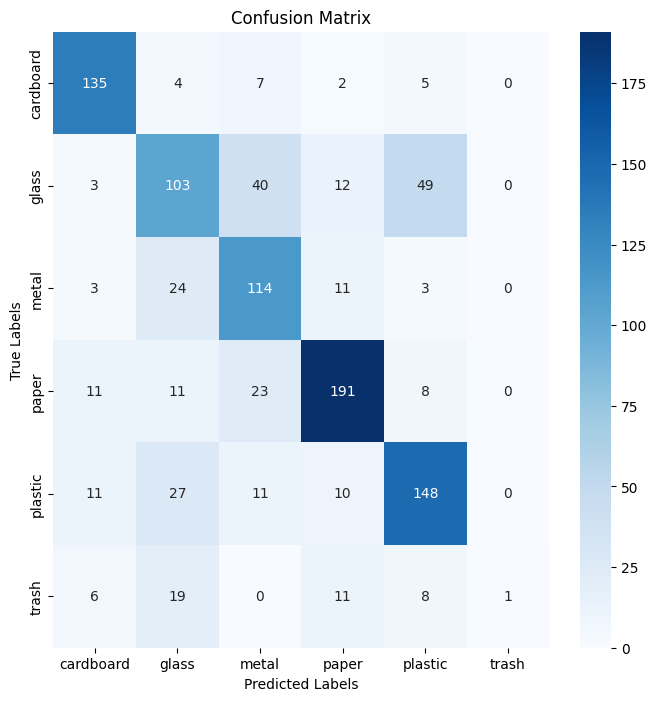

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.80      0.88      0.84       153
       glass       0.55      0.50      0.52       207
       metal       0.58      0.74      0.65       155
       paper       0.81      0.78      0.79       244
     plastic       0.67      0.71      0.69       207
       trash       1.00      0.02      0.04        45

    accuracy                           0.68      1011
   macro avg       0.73      0.61      0.59      1011
weighted avg       0.70      0.68      0.67      1011

Epoch 1/4 - Train Loss: 1.1651, Train Acc: 0.5657, Val Loss: 0.8632, Val Acc: 0.6845


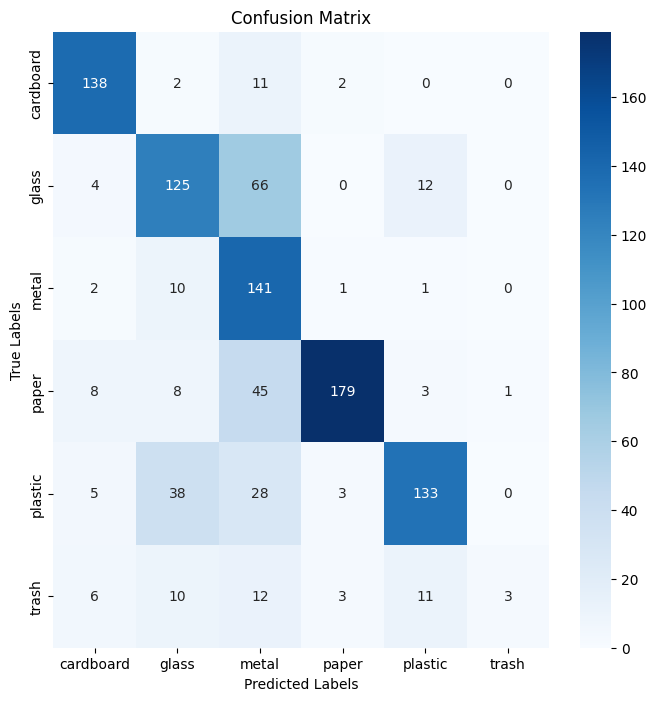

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.85      0.90      0.87       153
       glass       0.65      0.60      0.62       207
       metal       0.47      0.91      0.62       155
       paper       0.95      0.73      0.83       244
     plastic       0.83      0.64      0.72       207
       trash       0.75      0.07      0.12        45

    accuracy                           0.71      1011
   macro avg       0.75      0.64      0.63      1011
weighted avg       0.77      0.71      0.71      1011

Epoch 2/4 - Train Loss: 0.8120, Train Acc: 0.6982, Val Loss: 0.8106, Val Acc: 0.7112


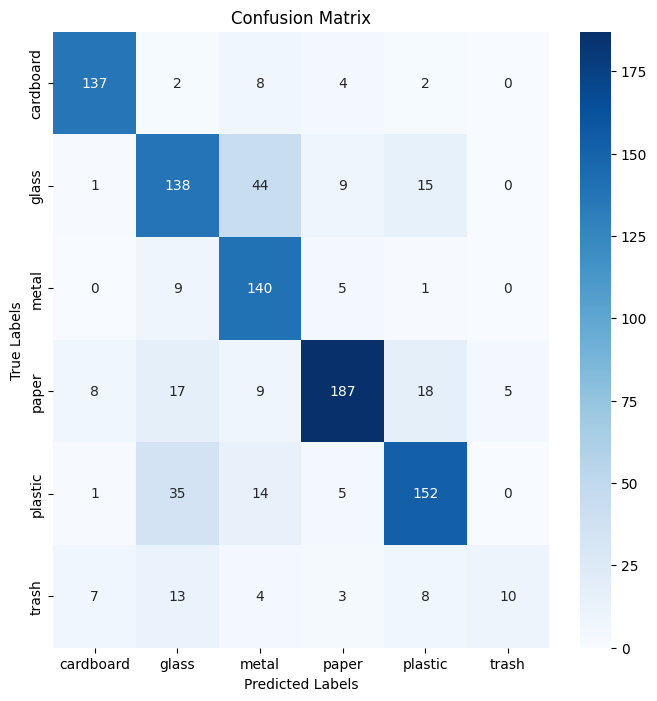

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.89      0.90      0.89       153
       glass       0.64      0.67      0.66       207
       metal       0.64      0.90      0.75       155
       paper       0.88      0.77      0.82       244
     plastic       0.78      0.73      0.75       207
       trash       0.67      0.22      0.33        45

    accuracy                           0.76      1011
   macro avg       0.75      0.70      0.70      1011
weighted avg       0.77      0.76      0.75      1011

Epoch 3/4 - Train Loss: 0.7119, Train Acc: 0.7430, Val Loss: 0.6761, Val Acc: 0.7557


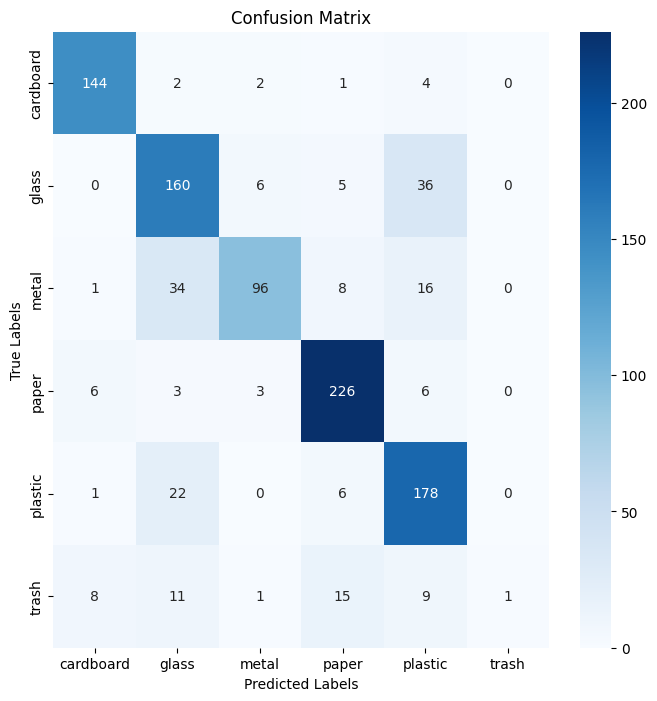

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.90      0.94      0.92       153
       glass       0.69      0.77      0.73       207
       metal       0.89      0.62      0.73       155
       paper       0.87      0.93      0.90       244
     plastic       0.71      0.86      0.78       207
       trash       1.00      0.02      0.04        45

    accuracy                           0.80      1011
   macro avg       0.84      0.69      0.68      1011
weighted avg       0.81      0.80      0.78      1011

Epoch 4/4 - Train Loss: 0.6166, Train Acc: 0.7757, Val Loss: 0.6274, Val Acc: 0.7962


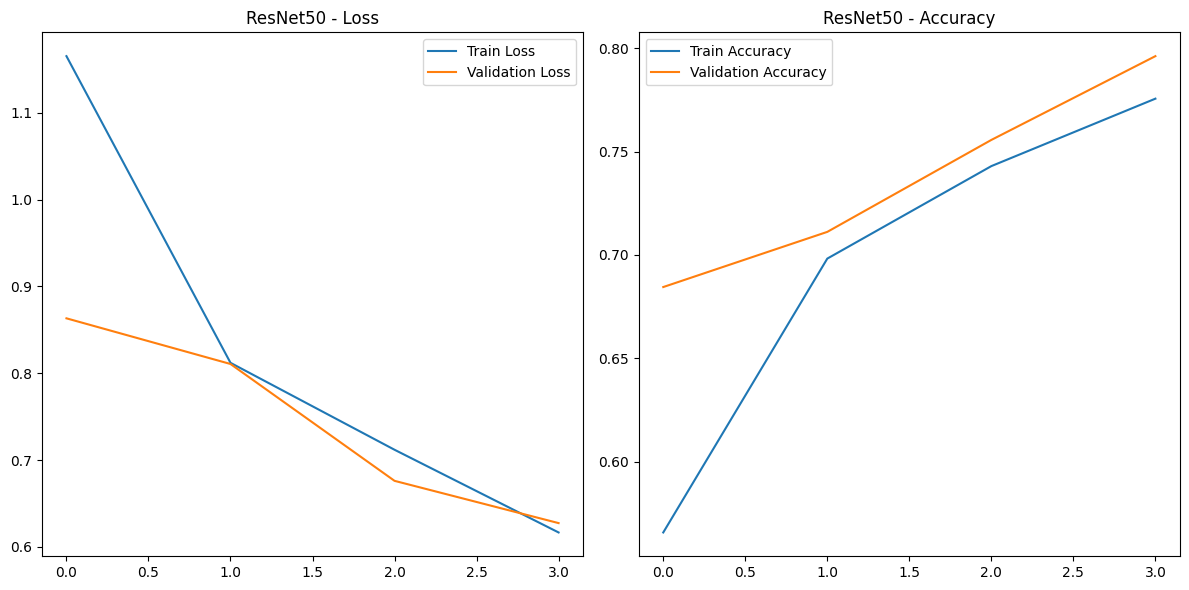

In [ ]:
# instantiate and train ResNet50
print("Training ResNet50...")
resnet50_model = create_model("resnet50")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)
history = train_model(resnet50_model, criterion, optimizer, train_loader, test_loader, epochs=4)
plot_training_history(history, "ResNet50")